In [3]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal


In [2]:
class QuardState(TypedDict):
    a:int
    b:int
    c:int
    equation: str
    discriminant: float
    result: str


In [6]:
def equation(state:QuardState):
    a=state['a']
    b=state['b']
    c=state['c']
    return {'equation':'f{a}X^2+{b}X+{c}'}
def calculate_d(state:QuardState):
    dis=state['b']**2-(4*state['a']*state['c'])
    return {'discriminant':dis}

def real_roots(state:QuardState):
    root1 = (-state["b"] + state["discriminant"]**0.5)/(2*state["a"])
    root2 = (-state["b"] - state["discriminant"]**0.5)/(2*state["a"])

    result = f'The roots are {root1} and {root2}'

    return {'result': result}

def repeated_roots(state: QuardState):

    root = (-state["b"])/(2*state["a"])

    result = f'Only repeating root is {root}'

    return {'result': result}

def no_real_roots(state: QuardState):

    result = f'No real roots'

    return {'result': result}

def check_condition(state:QuardState)->Literal["real_roots", "repeated_roots", "no_real_roots"]:

    if state['discriminant'] > 0:
        return "real_roots"
    elif state['discriminant'] == 0:
        return "repeated_roots"
    else:
        return "no_real_roots"

In [8]:
graph=StateGraph(QuardState)

graph.add_node('equation',equation)
graph.add_node('calculate_d',calculate_d)
graph.add_node('real_roots', real_roots)
graph.add_node('repeated_roots', repeated_roots)
graph.add_node('no_real_roots', no_real_roots)

graph.add_edge(START,'equation')
graph.add_edge('equation','calculate_d')
graph.add_conditional_edges('calculate_d',check_condition)
graph.add_edge('real_roots', END)
graph.add_edge('repeated_roots', END)
graph.add_edge('no_real_roots', END)

workflow=graph.compile()

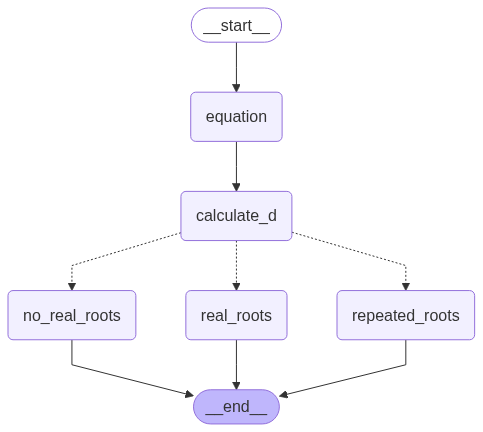

In [9]:
workflow

In [10]:
initial_state = {
    'a': 2, 
    'b': 4,
    'c': 2
}

workflow.invoke(initial_state)

{'a': 2,
 'b': 4,
 'c': 2,
 'equation': 'f{a}X^2+{b}X+{c}',
 'discriminant': 0,
 'result': 'Only repeating root is -1.0'}

## Review Reply using llm

In [13]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
load_dotenv()
groq_api=os.getenv('groq_api')
llm=ChatGroq(model='gemma2-9b-it',api_key=groq_api)

from pydantic import BaseModel,Field

In [51]:
class sentimentSchema(BaseModel):
    sentiment:Literal['positive','negative']=Field(description='Sentiment of the review')

In [37]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [52]:
structured_model = llm.with_structured_output(sentimentSchema)
structured_model2 = llm.with_structured_output(DiagnosisSchema)

In [54]:
class ReviewState(TypedDict):

    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str

In [86]:
def find_sentiment(state:ReviewState):
    review=state['review']
    prompt=f'what is the sentiment of this review \n {review}'
    output=structured_model.invoke(prompt).sentiment
    return {'sentiment':output}

def diagnosis_review(state:ReviewState):
    review=state['review']
    prompt=f"Find out issue type, tone and urgency of this negative sentiment review \n{review}"
    output=structured_model2.invoke(prompt)
    return {'diagnosis':output}

def negative_response(state:ReviewState):
    diagnosis = state['diagnosis']
    
    prompt = f"""You are a support assistant.
    The user had a '{diagnosis.issue_type}' issue, sounded '{diagnosis.tone}', and marked urgency as '{diagnosis.urgency}'.
    Write an empathetic, helpful resolution message.
    """
    output=llm.invoke(prompt).content
    return {'response':output}

def positive_response(state: ReviewState):

    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
    Also, kindly ask the user to leave feedback on our website."""
    
    response = llm.invoke(prompt).content

    return {'response': response}

def check_condition(state:ReviewState)->Literal["positive_response","diagnosis_review"]:
    if(state['sentiment']=='positive'):
        return 'positive_response'
    else:
        return 'diagnosis_review'
    




In [87]:
graph=StateGraph(ReviewState)

graph.add_node('find_sentiment',find_sentiment)
graph.add_node('diagnosis_review',diagnosis_review)
graph.add_node('negative_response',negative_response)
graph.add_node('positive_response',positive_response)

graph.add_edge(START,'find_sentiment')
graph.add_conditional_edges('find_sentiment',check_condition)
graph.add_edge('positive_response',END)
graph.add_edge('diagnosis_review','negative_response')
graph.add_edge('negative_response',END)


workflow=graph.compile()

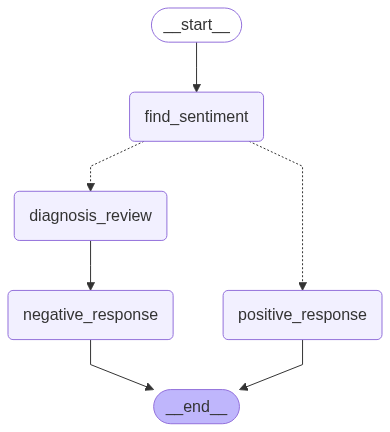

In [88]:
workflow

In [89]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': DiagnosisSchema(issue_type='Bug', tone='angry', urgency='high'),
 'response': "I understand you're frustrated with this bug and that it's causing a high level of urgency. I'm so sorry for the trouble it's causing! \n\nI want to help get this resolved for you as quickly as possible. To do that, could you please tell me a little more about the bug?  \n\nFor example:\n\n* What exactly is happening? \n* What were you trying to do when the bug occurred?\n* What steps have you already taken to try and fix it?\n\nThe more details you can provide, the better I can understand the issue and find a solution.  I'm here to work with you to get this sorted out. 😊  \n\n"}